# Aim

Go through all the steps of system identification for vibrations and make a better dynamic model of telescope tip-tilt aberrations based on that. This is first being built in this notebook, then it'll be incorporated into `tiptilt.py`.

## Steps

1. Make vibration data over some time.
2. Find its PSD.
3. Filter out measurement noise and curve-fit the PSD of measurement noise to find its spread.
4. Curve-fit remaining PSD to an atmosphere model.
5. Curve-fit remaining PSD to that of arbitrary vibration modes till a certain number of vibration modes has been reached or till the last one has negligible energy.
6. Construct Q based on the number of vibe modes.
7. Find AR2 state-evolution coefficients based on results of 4 and 5, and make new state-transition matrix A.
8. Run a simulation without filtering and without control action.
9. Run a simulation without filtering, but with control action.
10. Run a simulation with filtering and with control action.

In [1]:
# imports

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import periodogram
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 1 # number of vibration modes being applied
N_vib_max = 2 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook

Applied frequencies: [329.58278068]
Applied amplitudes: [0.63760098]
Applied amplitude polar angles: [6.22967036]
Applied phase offsets: [4.32387809]
Applied damping coefficients: [0.01488939]


Text(0.5,1,'Vibrations without measurement noise')

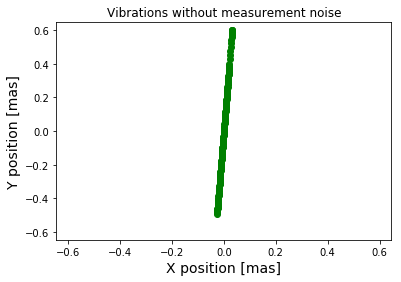

In [37]:
# step 1: making vibration data

times = np.arange(0, 0.2, 1/f_sampling)
vib_freqs    = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz (this should maybe be rad/s?)
vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase   = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping  = np.random.uniform(low=0.001, high=0.05, size=N_vib_app) # unitless

print("Applied frequencies: " + str(vib_freqs))
print("Applied amplitudes: " + str(vib_amps))
print("Applied amplitude polar angles: " + str(vib_pa))
print("Applied phase offsets: " + str(vib_phase))
print("Applied damping coefficients: " + str(vib_damping))

# vibrations are vib_amps[i] sin/cos(vib_pa[i]) exp(-vib_damping[i] vib_freqs[i] t) exp(i*(vib_freqs[i] t - vib_phase[i])).

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

# to do: investigate why this is not equivalent to the summation formulas I had in here before.
true_positions = np.zeros((len(times),2))
    
for i in range(N_vib_app):
    y_init_of_t = vib_amps[i]*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])*np.exp(-vib_damping[i]*vib_freqs[i]*times)
    x_init_of_t = np.zeros(len(times))
    positions_init = np.vstack((x_init_of_t, y_init_of_t))
    rotated_positions = np.dot(rotation_matrix(vib_pa[i]) , positions_init)
    true_positions = (true_positions + np.transpose(rotated_positions))
    
true_positions = true_positions.T
    
dx = true_positions[0]
dy = true_positions[1]

# measurement noise
dx_noisy = dx + np.random.normal(0, measurement_noise, np.size(times))
dy_noisy = dy + np.random.normal(0, measurement_noise, np.size(times))

plt.plot(dx, dy, 'go-', label='True positions')
#plt.plot(dx_noisy, dy_noisy, 'ro-', label='Noisy positions')
plt.xlabel('X position [mas]',fontsize=14)
plt.ylabel('Y position [mas]',fontsize=14)
lim = max(np.max(np.abs(dx_noisy)), np.max(np.abs(dy_noisy)))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
#plt.legend()
#plt.title('Vibrations with and without measurement noise')
plt.title('Vibrations without measurement noise')

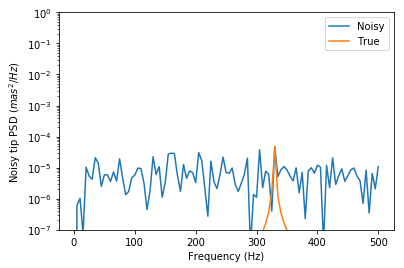

In [81]:
# step 2: find PSD

_, psd_tip_true = periodogram(dx, f_sampling)
freqs_tip, psd_tip = periodogram(dx_noisy, f_sampling)

plt.semilogy(freqs_tip, psd_tip, label='Noisy')
plt.semilogy(freqs_tip, psd_tip_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tip PSD $(mas^2/Hz)$")
plt.legend()

# PSD of white noise should be all above the true value?

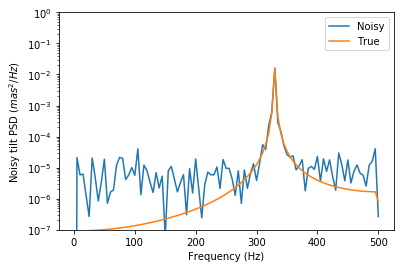

In [79]:
_, psd_tilt_true = periodogram(dy, f_sampling)
freqs_tilt, psd_tilt = periodogram(dy_noisy, f_sampling)

plt.semilogy(freqs_tilt, psd_tilt, label='Noisy')
plt.semilogy(freqs_tilt, psd_tilt_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tilt PSD $(mas^2/Hz)$")
plt.legend()

In [82]:
# step 3: filter out measurement noise

ind = max(np.argmax(freqs_tip > f_w), np.argmax(freqs_tilt > f_w))
assert ind != 0, "didn't find a high enough frequency"
noise_psd = (psd_tip[ind:] + psd_tilt[ind:])/2
avg_measurement_power = np.mean(noise_psd)

print(avg_measurement_power)
measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print("Recovered measurement noise: " + str(measurement_noise_recovered))
print("Percent error in measurement noise estimate: " + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

psd_tip -= avg_measurement_power
psd_tilt -= avg_measurement_power

# this subtraction is problematic because it goes negative...let's jank this a little
for psd in [psd_tip, psd_tilt]:
    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = 1e-6

1.614982670359085e-05
Recovered measurement noise: 0.12708196844395686
Percent error in measurement noise estimate: 111.80328073992811


Text(0.5,1,'Recovered and true PSDs')

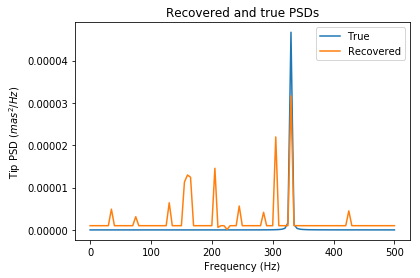

In [83]:
plt.plot(freqs_tip, psd_tip_true, label='True')
plt.plot(freqs_tip, psd_tip, label='Recovered')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Tip PSD $(mas^2/Hz)$")

plt.legend()
plt.title("Recovered and true PSDs")

Text(0.5,1,'Recovered and true PSDs')

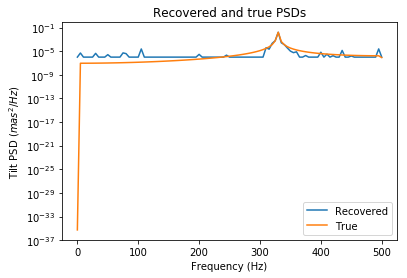

In [84]:
plt.semilogy(freqs_tilt, psd_tilt, label='Recovered')
plt.semilogy(freqs_tilt, psd_tilt_true, label='True') 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Tilt PSD $(mas^2/Hz)$")
plt.legend()
plt.title("Recovered and true PSDs")

In [85]:
# my suspicion at this stage is that with a more sophisticated white noise remover, the curve-fit will work better.
# we could try and make this sophisticated white noise remover, or we could just cheat:

psd_tip = psd_tip_true
psd_tilt = psd_tilt_true

In [95]:
# step 4: curve-fit the PSD

# don't know how realistic it is to set tip = real and tilt = imag, but I want to use exp but also not have both of 
# them totally in phase so it might as well work this way.

PARAMS_SIZE = 4

def vibe_psd(freq_in, A, f, k, p):
    vibe_time = A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)
    vibe_freq, vibe_strength = periodogram(vibe_time, f_sampling)
    if freq_in < np.min(vibe_freq) or freq_in > np.max(vibe_freq):
        return 0
    return interp1d(vibe_freq, vibe_strength)(freq_in)

vibe_psd = np.vectorize(vibe_psd)

N_vib_tip = 0
N_vib_tilt = 0
start_energy_tip = np.mean(psd_tip)
start_energy_tilt = np.mean(psd_tilt)

# This isn't really MLE but curve fitting should work too. 

# idea: Kalman filter _this_ and get a better estimate of freqs from freqs_tip and freqs_tilt off curve fit
# and same for damping.

params = np.zeros((N_vib_max*2, PARAMS_SIZE))
variances = np.zeros(N_vib_max*2)

par0 = [0.5, 200, 0, np.pi]
max_func_evals = 10000

while N_vib_tip < N_vib_max and np.mean(psd_tip) > energy_coeff * start_energy_tip:
    par, cov = curve_fit(vibe_psd, freqs_tip, psd_tip, par0, maxfev=max_func_evals)
    psd_tip -= vibe_psd(freqs_tip, *par)
    variances[N_vib_tip] = np.var(psd_tip) # psd_tip - vibe_psd already
    params[N_vib_tip] = np.array(par)
    N_vib_tip += 1
    
while N_vib_tilt < N_vib_max and np.mean(psd_tilt) > energy_coeff * start_energy_tilt:
    par, cov = curve_fit(vibe_psd, freqs_tilt, psd_tilt, par0, maxfev=max_func_evals)
    psd_tilt -= vibe_psd(freqs_tilt, *par)
    variances[N_vib_tip + N_vib_tilt] = np.var(psd_tilt)
    params[N_vib_tip + N_vib_tilt] = np.array(par)
    N_vib_tilt += 1

In [97]:
N_vib_tip, N_vib_tilt

(2, 1)

[[ 6.72341294e-05  1.91755427e+02  1.95090531e-01  4.81796795e+00]
 [-2.46891112e-04  1.91936599e+02  1.95380093e-01  4.32321030e+00]
 [ 2.40701148e-01  2.07082969e+03 -2.36971929e-03  3.25923104e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'Reconstructed and true y positions')

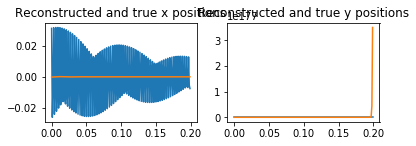

In [98]:
recon_dx = sum([params[i][0] * np.exp(-params[i][2] * params[i][1] * times)
          * np.sin(params[i][1] * times - params[i][3]) for i in range(N_vib_tip)])

recon_dy = sum([params[i][0] * np.exp(-params[i][2] * params[i][1] * times)
          * np.sin(1j * params[i][1] * times - params[i][3]) for i in range(N_vib_tip, N_vib_tip + N_vib_tilt)])

print(params)

plt.subplot(2,2,1)
plt.plot(times, dx, label='True')
plt.plot(times, recon_dx, label='Reconstructed from PSD')
plt.title("Reconstructed and true x positions")

plt.subplot(2,2,2)
plt.plot(times, dy, label='True')
plt.plot(times, recon_dy, label='Reconstructed from PSD')
plt.title("Reconstructed and true y positions")

[-1.61569092e-04 -1.34243644e-04 -1.03957841e-04 -7.20386631e-05
 -3.97772776e-05 -8.38416485e-06  2.10495419e-05  4.75835412e-05
  7.04520289e-05  8.90792414e-05  1.03086890e-04  1.12293803e-04
  1.16708343e-04  1.16514412e-04  1.12052014e-04  1.03793479e-04
  9.23165465e-05  7.82755182e-05  6.23716768e-05  4.53241185e-05
  2.78420358e-05  1.05993661e-05 -5.78743148e-06 -2.07778827e-05
 -3.39218746e-05 -4.48696727e-05 -5.33775244e-05 -5.93089637e-05
 -6.26320771e-05 -6.34131247e-05 -6.18070138e-05 -5.80452025e-05
 -5.24216628e-05 -4.52775604e-05 -3.69853067e-05 -2.79326136e-05
 -1.85071384e-05 -9.08223938e-06 -4.28567289e-09  8.41812364e-06
  1.59227741e-05  2.23001232e-05  2.73971973e-05  3.11191286e-05
  3.34284445e-05  3.43422995e-05  3.39278992e-05  3.22964146e-05
  2.95957203e-05  2.60023090e-05  2.17127368e-05  1.69349498e-05
  1.18798185e-05  6.75317608e-06  1.74861684e-06 -2.95873538e-06
 -7.21732964e-06 -1.09030555e-05 -1.39218226e-05 -1.62108507e-05
 -1.77387155e-05 -1.85042

Text(0.5,1,'Reconstructed and true x positions')

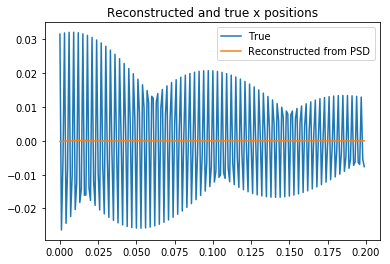

In [99]:
plt.plot(times, dx, label='True')
plt.plot(times, recon_dx, label='Reconstructed from PSD')
plt.legend()
plt.title("Reconstructed and true x positions")

In [ ]:
# okay, not bad, but there are problems either from the still-noisy PSD (don't think much can be done about that)
# or from the greedy approach to vibe mode fitting (can maybe fix by doing actual MLE and not just scipy curve_fit.)

In [ ]:
# step 5: define Q for tip and tilt, then combine them for our eventual full dynamic system.

# problem: how do you propagate dependent uncertainties?
# solution: you don't

# problem: how do you estimate sigma if you can't propagate dependent uncertainties?
# solution: mildly jank it

num_vibe_modes = N_vib_tip + N_vib_tilt
STATE_SIZE = 2*num_vibe_modes + 2 # vibe modes, vibe modes one timestep ago, dx, dy
Q = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(num_vibe_modes):
    Q[2*i][2*i] = variances[i]
    
# do you set up dx and dy process noise? nop

In [ ]:
# step 6: find AR2 state-evolution coefficients and construct A

# convention: a_ji, j is the number of the coefficient (1 or 2), i is the number of the vibe mode

A = np.zeros((STATE_SIZE, STATE_SIZE))
for i in np.arange(0, STATE_SIZE, 2):
    k = params[i][2]
    f = params[i][1]
    a_1i = 2 * np.exp(-2*k*np.pi*f/f_sampling) * np.cos(2*np.pi*f*np.sqrt(1-k**2)/f_sampling)
    a_2i = np.exp(-4*k*np.pi*f/f_sampling)
    A[i][i] = a_1i
    A[i][i+1] = a_2i
    A[i+1][i] = 1

In [ ]:
# step 7: set up state-space model

# all of this stuff will be moved into a DynamicSystem child class later.
# DynamicSystem isn't set up to deal with the D matrix.
# Right now, for independence, I'm going to copy over the predict and update methods and run them in a loop.


INPUT_SIZE = 2 # but this is only applied to the measurements
MEASUREMENT_SIZE = 2 # measuring dx, dy

state_init = np.random.normal(0, np.diag(Q), STATE_SIZE) 
# state starts with white process noise, otherwise it never evolves.
# state doesn't include dx and dy and has no dependence on the control input
# so if it's not started at something nonzero and allowed to evolve based on sysID
# then vibrations are just identified as zero for all time.
# this seems sketchy though.

H = np.zeros((2, STATE_SIZE))
for i in np.arange(0, 2*N_vib_tip, 2):
    H[0][i] = 1

for i in np.arange(2*N_vib_tip, STATE_SIZE, 2):
    H[1][i] = 1
    
P = np.zeros((STATE_SIZE, STATE_SIZE))
R = measurement_noise * np.identity(MEASUREMENT_SIZE)
D = np.identity(2)

def evolve():
    return (A, np.zeros((STATE_SIZE, INPUT_SIZE)))

def ext_input(state):
    return -H.dot(state)

def predict(state):
    # predicts system state at time t+dt based on system state at time t
    A, B = evolve()
    u = ext_input(state)
    state_predicted = A.dot(state) + B.dot(u)
    P_predicted = A.dot(P.dot(A.T)) + Q
    return (u, state_predicted, P_predicted)

def measure(state, u):
    return H.dot(state) - D.dot(u) # currently ignoring the loop time delay.

def update(state_predicted, P_predicted, measurement):
    error = measurement - measure(state_predicted)
    K = P_predicted.dot(H.T.dot(np.linalg.inv(H.dot(P_predicted.dot(H.T)) + R)))
    state_updated = state_predicted + K.dot(error)
    P_updated = P_predicted - K.dot(H.dot(P_predicted))
    return (state_updated, P_updated)

In [ ]:
# step 8: simulate without filtering and without applying any control input.

state = state_init
t_max = 10
dt = 1/f_sampling
t, k = 0, 1
D = np.zeros((2,2)) # I think? x only updates the vibrations, which are random around the origin.
y = np.zeros((t_max * f_sampling, INPUT_SIZE)) # y vector, not physical y.
y[0] = state_init
while t < t_max:
    u, state, _ = predict(state)
    y[k] = measure(state, u)
    k += 1
    t += dt

y = y.T
plt.plot(y[0], y[1])
plt.xlabel("x vibrations (mas)")
plt.ylabel("y vibrations (mas)")
plt.title("Uncorrected vibrations")

In [ ]:
# going to do steps 9 and 10 after I've confirmed 1-8 work